# Aerial Project

## Starting Kit for raw data (images)

Created by Aerial Team

ALL INFORMATION, SOFTWARE, DOCUMENTATION, AND DATA ARE PROVIDED "AS-IS". The CDS, CHALEARN, AND/OR OTHER ORGANIZERS OR CODE AUTHORS DISCLAIM ANY EXPRESSED OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR ANY PARTICULAR PURPOSE, AND THE WARRANTY OF NON-INFRIGEMENT OF ANY THIRD PARTY'S INTELLECTUAL PROPERTY RIGHTS. IN NO EVENT SHALL AUTHORS AND ORGANIZERS BE LIABLE FOR ANY SPECIAL, INDIRECT OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES WHATSOEVER ARISING OUT OF OR IN CONNECTION WITH THE USE OR PERFORMANCE OF SOFTWARE, DOCUMENTS, MATERIALS, PUBLICATIONS, OR INFORMATION MADE AVAILABLE FOR THE CHALLENGE.

## Introduction

Aerial imagery has been a primary source of geographic data for quite a long time. With technology progress, aerial imagery became really practical for remote sensing : the science of obtaining information about an object, area or phenomenon.
Nowadays, there are many uses of image recognition spanning from robotics/drone vision to autonomous driving vehicules or face detection.

In this challenge, we will use pre-processed data, coming from landscape images. The goal is to learn to differentiate common and uncommon landscapes such as a beach, a lake or a meadow.
Data comes from part of the data set (NWPU-RESISC45) originally used in the paper [*Remote Sensing Image Scene Classification*](https://arxiv.org/pdf/1703.00121.pdf). This data set contains 45 categories while we only kept 13 out of them.

References and credits:

Yuliya Tarabalka, Guillaume Charpiat, Nicolas Girard for the data sets presentation.<br>
Gong Cheng, Junwei Han, and Xiaoqiang Lu, for the original article on the chosen data set.
</div>

### Requirements / Installation

```bash
conda create -n torch python=3
conda activate torch
conda install pytorch torchvision torchaudio -c pytorch
conda install ipykernel pyyaml pandas matplotlib scipy scikit-learn
```

Code tested with:

```
python=3.9.7
pytorch=1.10.0
pyyaml=6.0
pandas=1.3.4
matplotlib=3.5.0
scipy=1.7.1
scikit-learn=1.0.1
```

In [1]:
import csv
import platform
import shutil
from collections import namedtuple
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn import decomposition, metrics, model_selection, naive_bayes, pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
if platform.system() == "Darwin":
    %config InlineBackend.figure_format="retina"  # For high DPI display

print(sklearn.__version__)  # Version tested on sklearn.__version__ == 1.0.1

1.0.1


In [3]:
DATA_PATH = Path("public_data")

SUBM_PATH = Path("submissions")
RESULTS_PATH = SUBM_PATH / "submission_results"

DATA_NAME = "Areal"

DATA_SETS = ["train", "valid"]

## Step 1: Exploratory data analysis

### Load data

In [4]:
def number_lines(fname):
    with open(fname) as f:
        return sum(1 for l in f)

In [5]:
def fast_import(arr, fpath):
    with open(fpath) as f:
        for i, row in enumerate(csv.reader(f, delimiter=" ")):
            arr[i] = row

In [6]:
num_fts = number_lines(DATA_PATH / f"{DATA_NAME}_feat.name")

num = {
    data_set: number_lines(DATA_PATH / f"{DATA_NAME}_{data_set}.data")
    for data_set in DATA_SETS
}

xs_raw = {
    data_set: np.empty((num[data_set], num_fts))
    for data_set in DATA_SETS
}

for data_set in DATA_SETS:
    fast_import(
        xs_raw[data_set], 
        fpath=DATA_PATH / f"{DATA_NAME}_{data_set}.data"
    )

In [7]:
labels_df = pd.read_csv(
    DATA_PATH / f"{DATA_NAME}_label.name", header=None, names=["name"]
)

labels = labels_df.name.to_list()

ys_df = pd.read_csv(
    DATA_PATH / f"{DATA_NAME}_train.solution", header=None, names=["value"]
)

ys_raw = ys_df.values

ys_df["label"] = ys_df.value.map(labels_df.name)

ys_df.head()

,value,label
0,5,island
1,0,beach
2,0,beach
3,1,chaparral
4,0,beach


### Visualize dataset sample

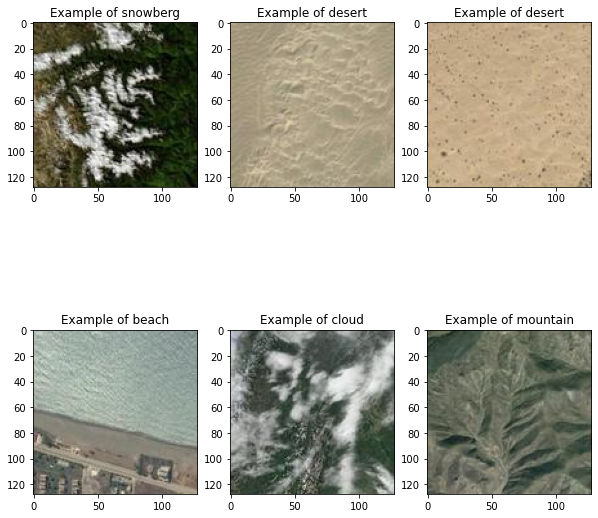

In [17]:
NUM_TO_SHOW = 6

fig, axs_ = plt.subplots(nrows=2, ncols=3, figsize=(10, 10))
fig.subplots_adjust(hspace=0.3)
axs = axs_.flatten()

idx = np.random.randint(ys_df.count()['value'] - 1 - NUM_TO_SHOW)

for i in range(NUM_TO_SHOW):
    img = xs_raw["train"][[idx + i].reshape(128, 128, 3)
    label = ys_df.label[[idx + i]
    axs[i].set_title(f"Example of {label}")
    axs[i].imshow(img.astype(float) / 255)

plt.show()

## Step 2 : Building a predictive model

### Baseline model

In [28]:
print(xs_raw['test'].shape)

(1950, 49152)


We split the dataset in 2: the train set and the validation set

In [11]:
xs, ys = {}, {}

xs["train"], xs["valid"], ys["train"], ys["valid"] = model_selection.train_test_split(
    xs_raw["train"], ys_raw, random_state=1
)

xs["valid"] = xs_raw["valid"]

print(xs_raw["train"].shape, ys_raw.shape)
print(xs["train"].shape, ys["train"].shape)
print(xs["valid"].shape, ys["valid"].shape)

(5200, 49152) (5200, 1)
(3900, 49152) (3900, 1)
(1950, 49152) (1300, 1)


In [12]:
print(xs_raw['train'])

[[109. 134. 112. ... 107. 127. 102.]
 [ 68.  73.  66. ... 115. 108. 100.]
 [119. 142. 122. ... 134. 135. 140.]
 ...
 [179. 164. 145. ... 161. 146. 125.]
 [ 93. 113.  88. ...  62.  88.  59.]
 [133. 130. 121. ... 114. 112.  97.]]


We verify there are no NaN in the dataset

In [101]:
print(pd.isna(xs['train']).any())
print(pd.isna(ys['train']).any())
print(pd.isna(xs['valid']).any())
print(pd.isna(ys['valid']).any())

# There are no NaN

False
False
False
False


In [32]:
print(ys["train"].shape)
ys['train'][:10] # We print the head of ys

(3900, 1)


array([[ 3],
       [ 0],
       [ 7],
       [ 5],
       [ 0],
       [ 7],
       [10],
       [ 6],
       [ 0],
       [ 8]], dtype=int64)

We encode the labels in one hot vectors to fit the requirements of a neural network

In [ ]:
def encode(ds):
    nb_cat = 13
    ret = np.zeros((ds.shape[0], nb_cat))
    for i in range(ds.shape[0]):
        ret[i][ds[i]] = 1
    return ret

In [ ]:
#Encoding

for typ in DATA_SETS:
    ys[typ] = encode(ys[typ])

In [ ]:
print(ys['train'].shape)
ys['train'][:10]

Plotting the label frequency

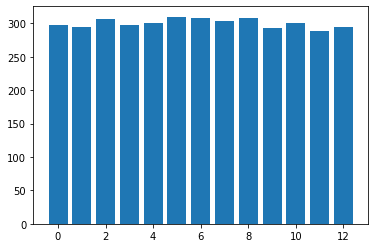

In [40]:
plt.bar(np.arange(0,13), sum(ys['train']))
plt.show()

The dataset is well balanced

We standardise the dataset using min-max standardisation

In [ ]:
# Standardization

sd_max = max([max(xs['train'][i]) for i in range(xs['train'].shape[0])])
sd_min = min([min(xs['train'][i]) for i in range(xs['train'].shape[0])])

print(f"Max: {sd_max}")
print(f"Min: {sd_min}")


for typ in DATA_SETS:
    xs[typ] = (xs[typ] - sd_min) / sd_max

We import PyTorch libraries

In [49]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.transforms import ToTensor
from torchvision import transforms
import psutil

We convert our data in Pytorch Tensors to be able to use Pytorch

In [50]:
# Data transformation to Tensors

image_train = []
label_train = []

for image in xs['train']:
    image_train.append(ToTensor()(image.reshape(128, 128, 3))) # We convert each image to Tensor from PyTorch

image_train = torch.stack(image_train)
label_train = torch.FloatTensor(ys['train'])

In [51]:
print(image_train.shape)
print(label_train.shape)

torch.Size([3900, 3, 128, 128])
torch.Size([3900, 13])


In [52]:
# Data transformation to Tensors

image_valid = []
label_valid = []

for image in xs['valid']:
    image_valid.append(ToTensor()(image.reshape(128, 128, 3)))

image_valid = torch.stack(image_valid)
label_valid = torch.FloatTensor(ys['valid'])

In [53]:
print(image_valid.shape)
print(label_valid.shape)

torch.Size([1300, 3, 128, 128])
torch.Size([1300, 13])


We create a Dataset class to be able to manipulate the data before sending it to the convolutional neural network

In [46]:
# Dataset Class creation

class Dataset(torch.utils.data.Dataset): # We use the map-style dataset
  'Characterizes a dataset for PyTorch'
  def __init__(self, labels, images):
        'Initialization'
        self.labels = labels
        self.images = images

  def __len__(self):
        'Denotes the total number of samples'
        return self.labels.shape[0]

  def __getitem__(self, index):
        'Generates one sample of data'
        
        # Load data and get label
        X = self.images[index]
        y = self.labels[index]

        return X, y

This next Dataset class uses transformations from PyTorch to perform data augmentation

We have:<br>
- Random rotation
- Random zoom
- Random flip
- Random adjusments of brightness/contrast/saturation

In [45]:
# Dataset Class creation with data augmentation

class Dataset2(torch.utils.data.Dataset):
    
    'Characterizes a dataset for PyTorch'
    def __init__(self, labels, images):
        'Initialization'
        self.labels = labels
        self.images = images

    def __len__(self):
        'Denotes the total number of samples'
        return self.labels.shape[0]

    def __getitem__(self, index):
        'Generates one sample of data'
        
        # Load data and get label
        X = self.images[index]
        y = self.labels[index]
        
        X = self.transform(X)

        return X, y
    
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(128),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
    ])

We instanciate 2 DataLoader forms from which we will load the data during the training phase

In [54]:
batch_size = 128 # How many samples per batch we load

trainset = Dataset2(label_train, image_train)

validset = Dataset(label_valid, image_valid)

trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size,
                                         shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size = batch_size * 4,
                                         shuffle=True)

We test these loaders

In [62]:
data = next(iter(trainloader))
print(data[0].shape)
print(data[1].shape)

data = next(iter(validloader))
print(data[0].shape)
print(data[1].shape)

torch.Size([128, 3, 128, 128])
torch.Size([128, 13])
torch.Size([512, 3, 128, 128])
torch.Size([512, 13])


We show some images after data augmentation

torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([128, 128, 3])
torch.Size([128, 128, 3])
torch.Size([128, 128, 3])


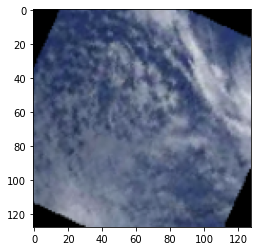

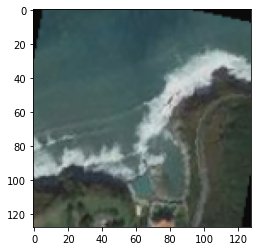

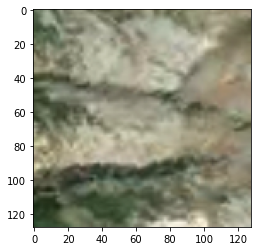

In [71]:
to_show1 = next(iter(trainloader))[0][0]
to_show2 = next(iter(trainloader))[0][0]
to_show3 = next(iter(trainloader))[0][0]
print(to_show1.shape)
print(to_show2.shape)
print(to_show3.shape)
img1 = to_show1.permute(1,2,0)
img2 = to_show2.permute(1,2,0)
img3 = to_show3.permute(1,2,0)
print(img1.shape)
print(img2.shape)
print(img3.shape)
plt.imshow(img1.numpy())
plt.show()
plt.imshow(img2.numpy())
plt.show()
plt.imshow(img3.numpy())
plt.show()

We define the Convolutional Neural Network using convolutional layers, reLU activation, MaxPool normalization <br>
We finish the network with a simple fully connected network with reLu activation <br>
We do not use softmax here because it is already in the criterion

In [75]:
# Defining CNN architecture

class Conv_Net(nn.Module):
    def __init__(self):
        super().__init__() #3*128*128
        # We apply two 2D convolutions layers
        self.conv1a = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, stride = 1, padding = 1) #16*128*128
        self.conv1b = nn.Conv2d(16, 64, 3, 1, 1) #64*128*128
        # We apply five 2D max pooling, it takes the largest pixel received
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2) #64*64*64
        self.conv2 = nn.Conv2d(64, 128, 3, 1, 1) #128*64*64
        self.pool2 = nn.MaxPool2d(2, 2) #128*32*32
        self.conv3 = nn.Conv2d(128, 256, 3, 1, 1) #256*32*32
        self.pool3 = nn.MaxPool2d(2, 2) #256*16*16
        self.conv4 = nn.Conv2d(256, 512, 3, 1, 1) #512*16*16
        self.pool4 = nn.MaxPool2d(2, 2) #512*8*8
        self.conv5 = nn.Conv2d(512, 512, 3, 1, 1) #512*8*8
        self.pool5 = nn.MaxPool2d(2, 2) #512*4*4
        # We create four linear layers to transform the data
        self.fc1 = nn.Linear(in_features = 512 * 4 * 4, out_features = 4096)
        self.fc2 = nn.Linear(4096, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 13)

    def forward(self, x):
        # Finally we use the rectified linear unit activation function
        # It results giving if yes or no the image belongs to a category
        x = self.pool1(F.relu(self.conv1b(F.relu(self.conv1a(x)))))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))
        x = self.pool5(F.relu(self.conv5(x)))
        x = x.view(-1, 512 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [134]:
PATH = "save/save_v7.pth"

Initializing GPU device, criterion which is the loss function and the optimizer which will set the learning rate during the training

In [81]:
device = "cuda" if torch.cuda.is_available() else "cpu" # Verify if you have the required CUDA libraries and NVIDIA drivers

net = Conv_Net().to(device) # It allows to move the neural network to the device
#net.load_state_dict(torch.load(PATH)) #if we already used a neural network before
net = net.float() # Casts all the data to float type

criterion = nn.CrossEntropyLoss().to(device) # We use the cross entropy loss
optimizer = torch.optim.Adam(net.parameters(), lr = 0.0002) # I decided to implement Adam algorithm as it is close the stochastic gradient descent

The following cell trains the network, evaluates it each 20 epochs, and saves the models if the accuracy is better than all the previous ones

In [99]:
data = next(iter(trainloader)) # We treat each data
images, targets = data[0].to(device), data[1].to(device)

tensor([-0.0139, -0.0263,  0.0090, -0.0518,  0.0346, -0.0055,  0.0729, -0.0144,
        -0.0473,  0.0821,  0.0246, -0.0865, -0.0467],
       grad_fn=<SelectBackward0>)

In [365]:
# Train loop

max_acc_val = 0

train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

epoch = 10000

for i in range(epoch):
    data = next(iter(trainloader)) # We treat each data
    images, targets = data[0].to(device), data[1].to(device)
    optimizer.zero_grad() # We reset the gradient
    outputs = net(images.float()) # We get output after the images goes through the neural network
    lossT = criterion(outputs, torch.max(targets, 1)[1])
    lossT.backward() # Compute the gradient
    optimizer.step() # Update the optimizer for each value 
    #print('RAM memory % used:', psutil.virtual_memory())
    if i % 20 == 0: # Each 20 iteration, 
        net.eval() # We set the neural net to evaluation mode
        optimizer.zero_grad()
        valid_data = next(iter(validloader))
        imagesV, targetsV = valid_data[0].to(device), valid_data[1].to(device)
        outV = net(imagesV.float())
        lossV = criterion(outV, torch.max(targetsV, 1)[1]) # We calculate the loss thanks to the valid data
        t_acc = torch.sum(torch.max(outputs, 1)[1] == torch.max(targets,1)[1]) / outputs.shape[0] #torch.sum returns the sum of all elements in the input tensor
        v_acc = torch.sum(torch.max(outV, 1)[1] == torch.max(targetsV,1)[1]) / outV.shape[0]
        print(f"epoch n{round(i / 20)}")
        print(f"train loss: {lossT}      train accuracy: {t_acc}")
        print(f"valid loss: {lossV}      valid accuracy: {v_acc}")
        print("---------------------------------------------------")
        train_loss.append(lossT.detach().item()) # We stack all the previous loss
        valid_loss.append(lossV.detach().item())
        train_acc.append(t_acc.detach().item())
        valid_acc.append(v_acc.detach().item())
        
        if v_acc > max_acc_val:
            max_acc_val = v_acc
            PATH = f"save/save_{v_acc}.pth"
            torch.save(net.state_dict(), PATH)
        
        net.train() # We go back to training mode
        del imagesV, targetsV, valid_data, outV, t_acc, v_acc, lossV # We delete all these data

epoch n0
train loss: 0.47365859150886536      train accuracy: 0.8671875
valid loss: 0.2757543921470642      valid accuracy: 0.931640625
---------------------------------------------------
epoch n1
train loss: 0.14973948895931244      train accuracy: 0.9375
valid loss: 0.2026064544916153      valid accuracy: 0.921875
---------------------------------------------------
epoch n2
train loss: 0.3533196449279785      train accuracy: 0.875
valid loss: 0.3108695447444916      valid accuracy: 0.908203125
---------------------------------------------------
epoch n3
train loss: 0.2666440010070801      train accuracy: 0.8828125
valid loss: 0.3403773307800293      valid accuracy: 0.896484375
---------------------------------------------------
epoch n4
train loss: 0.3824118375778198      train accuracy: 0.8984375
valid loss: 0.27117204666137695      valid accuracy: 0.9140625
---------------------------------------------------
epoch n5
train loss: 0.20616541802883148      train accuracy: 0.9375
valid

KeyboardInterrupt: 

We plot the loss of the train/validation set

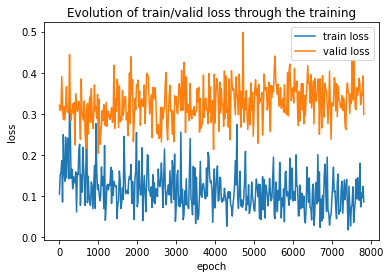

In [178]:
plt.plot(np.arange(0,len(train_loss) * 20, 20), train_loss, label = 'train loss')
plt.plot(np.arange(0,len(valid_loss) * 20, 20), valid_loss, label = 'valid loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Evolution of train/valid loss through the training')
plt.legend()
plt.show()

We plot the accuracy of the train/validation set

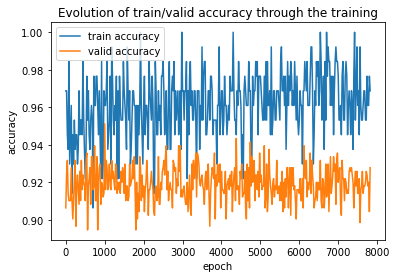

In [179]:
plt.plot(np.arange(0,len(train_acc)*20, 20), train_acc, label = 'train accuracy')
plt.plot(np.arange(0,len(valid_acc)*20, 20), valid_acc, label = 'valid accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Evolution of train/valid accuracy through the training')
plt.legend()
plt.show()

We transform the test data into Pytorch Tensors 

In [40]:
# Predicting

image_test = []

for image in xs['test']:
    image_test.append(ToTensor()(image.reshape(128,128,-1)))

image_test = torch.stack(image_test)

print(image_test.shape)

torch.Size([1950, 3, 128, 128])


The following function passes the data through the network while applying some data augmentation if instructed <br>
The data augmentation on an image creates 5 images who pass through a transformer, they all get a prediction and we choose the most seen prediction as the final one for the given image

In [42]:
def pred(images, net_PATH, batch_size = 400, augment_mode = False):
    # batch_size is the number of images passing through the network at the same time, its value depends on the GPU RAM size
    out = []
    net = Conv_Net().to(device)
    net.load_state_dict(torch.load(PATH)) # We load the parameters we used to train the neural network
    net = net.float()
    net.eval()
    
    if augment_mode: # We apply the data augmentation we did before
        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(30),
            transforms.RandomResizedCrop(128),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
        ])
        aug_images = []
        for i in range(images.shape[0]):
            aug = [images[i]]
            for j in range(5): # We create 5 more images which will pass in the transformers
                aug.append(transform(images[i]))
            aug_images.append((torch.cat(aug)))
        images = torch.reshape(torch.cat(aug_images), (images.shape[0]*6,3,128,128))

    nb_batches = images.shape[0] / batch_size
    last_b_size = int(np.round(batch_size * (nb_batches - np.floor(nb_batches))))
    if last_b_size == 0: last_b_size = batch_size
    nb_batches = int(np.ceil(nb_batches))
    print(nb_batches, last_b_size)
    for i in range(nb_batches):
        if i != nb_batches - 1:
            out.append(torch.max(net(images[i * batch_size:(i + 1) * batch_size].float()), axis = 1)[1])
        else:
            out.append(torch.max(net(images[i * batch_size:(i * batch_size + last_b_size)].float()), axis = 1)[1])
    if augment_mode:
        out = torch.reshape(torch.cat(out), (int(images.shape[0] / 6), 6))
        return torch.mode(out, dim = 1)[0].tolist()
    return torch.cat(out).tolist()

# My teacher helped me to make this function

We test the prediction on the valid set with and without the augmentation method

In [38]:
# Testing on validation set

p_a = pred(image_valid, PATH, augment_mode = True) #prediction with augmentation
p = pred(image_valid, PATH) #prediction without augmentation

20 200
4 100


In [39]:
print("Augmented prediction score: ", float(sum(torch.Tensor(p_a) == torch.max(label_valid, dim = 1)[1]) / len(p_a)))
print("Standard prediction score: ", float(sum(torch.Tensor(p) == torch.max(label_valid, dim = 1)[1]) / len(p_a)))

Augmented prediction score:  0.9346153736114502
Standard prediction score:  0.9269230961799622


We get better accuracy with augmented prediction method

If we want to make our own prediction for a chosen image online we can use the following cell

In [133]:
from PIL import Image
import requests
url = "your url"
im = Image.open(requests.get(url), stream=True).raw
im = im.resize(128, 128)
im = np.array(im)[:, :, :3] # We remove the alpha channel if the image is in PNG format
plt.imshow(im)
plt.show()

image_test = []
image_test.append(ToTensor()(im.reshape(128, 128, 3)))

image_test = torch.stack(image_test)

print('We predict :'pred(image_test, PATH, augment_mode = True))

# Machine Learning approach

We apply a PCA to the dataset

In [13]:
N_COMP = 40

scaler = StandardScaler()
pca = decomposition.PCA(n_components = N_COMP)

preproc_pipe = pipeline.Pipeline(steps=[("scaler", scaler), ("pca", pca)])  

preproc_pipe.fit(xs["train"])

xps = {
    data_set: preproc_pipe.transform(xs[data_set]) 
    for data_set in DATA_SETS
} # We use pipeline to scale and reduce the dimension of the data

In [14]:
print(pca.explained_variance_ratio_.shape)

print(f"{pca.explained_variance_ratio_.cumsum()[-1]:.3f}")

(40,)
0.799


We train different models in scikit-learn and print the accuracy score on the train set and the validation set

In [121]:
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn import ensemble
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

models = [
    naive_bayes.GaussianNB(),
    Perceptron(tol = 1e-3),
    KNeighborsClassifier(n_neighbors = 3),
    LinearSVC(tol = 1e-5),
    ensemble.RandomForestClassifier(n_estimators = 10),
    GradientBoostingClassifier(n_estimators = 100, learning_rate = 1.0, max_depth = 1),
    MLPClassifier(max_iter = 500, hidden_layer_sizes = [200, 100, 50, 25]),
]

for model in models:
    print(model)
    model.fit(xps["train"], np.argmax(ys["train"], axis = 1))  # training 
     
    pred = {
        data_set: model.predict(xps[data_set]) 
        for data_set in ALL_SETS
    }
    
    print(sklearn.metrics.accuracy_score(np.argmax(ys["train"], axis = 1), pred['train']))
    print(sklearn.metrics.accuracy_score(np.argmax(ys["valid"], axis = 1), pred['valid']))

GaussianNB()
0.4907692307692308
0.46307692307692305
Perceptron()
0.23358974358974358
0.21846153846153846
KNeighborsClassifier(n_neighbors=3)
0.6566666666666666
0.4592307692307692
LinearSVC(tol=1e-05)
0.24871794871794872
0.22230769230769232
RandomForestClassifier(n_estimators=10)
0.9917948717948718
0.5007692307692307
GradientBoostingClassifier(learning_rate=1.0, max_depth=1)
0.06846153846153846
0.07307692307692308
MLPClassifier(hidden_layer_sizes=[200, 100, 50, 25], max_iter=500)
0.9720512820512821
0.5207692307692308


We search the best hyper-parameters for RandomForestClassifier using RandomizedSearchCV with Cross Validation

In [116]:
from sklearn.model_selection import RandomizedSearchCV

distribution = dict(n_estimators=[5,10,50,100,200],
                    min_samples_split=[2,3,5,10],
                    min_samples_leaf=[1,2,3,4,5],
                    max_features=['auto', 'sqrt', 'log2'])
            
CV = 10
    
RandomForestClassifier = ensemble.RandomForestClassifier()
clf = RandomizedSearchCV(RandomForestClassifier,distribution, cv=CV)
search = clf.fit(xps["valid"], np.argmax(ys["valid"], axis = 1))
search.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 5,
 'max_features': 'auto'}

In [117]:
model = ensemble.RandomForestClassifier(n_estimators=200,min_samples_split=5, min_samples_leaf=5, max_features='auto')

model.fit(xps["train"], np.argmax(ys["train"], axis = 1))    # WITH PCA: xps, Without PCA: xs

RandomForestClassifier(min_samples_leaf=5, min_samples_split=5,
                       n_estimators=200)

In [118]:
# WITH PCA: xps, Without PCA: xs
pred = {
    data_set: model.predict(xps[data_set]) 
    for data_set in ALL_SETS
}

In [119]:
print(sklearn.metrics.accuracy_score(np.argmax(ys["train"], axis = 1),pred['train']))
print(sklearn.metrics.accuracy_score(np.argmax(ys["valid"], axis = 1),pred['valid']))

0.9648717948717949
0.6338461538461538


## Scoring the result

### Confusion matrix of the CNN

In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Confusion Matrix for best model

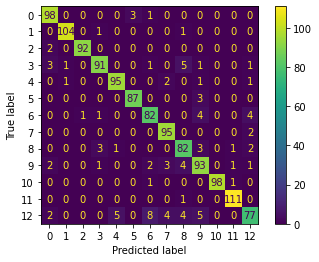

In [102]:
cm = confusion_matrix(np.argmax(ys['valid'], axis = 1).reshape(-1), pred_cm)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = np.arange(0, 13, 1))
disp.plot()

Displaying names corresponding to label indices

In [104]:
names = ['beach','chaparral','cloud','desert','forest','island','lake','meadow','mountain','river','sea','snowberg','wetland']

for i in range(len(names)):
    print(f"{i} corresponds to {names[i]} \n")

0 corresponds to beach 

1 corresponds to chaparral 

2 corresponds to cloud 

3 corresponds to desert 

4 corresponds to forest 

5 corresponds to island 

6 corresponds to lake 

7 corresponds to meadow 

8 corresponds to mountain 

9 corresponds to river 

10 corresponds to sea 

11 corresponds to snowberg 

12 corresponds to wetland 



In [128]:
methods = ['GaussianNB', 'Perceptron', 'KNeighborsClassifier','LinearSVC','RandomForestClassifier', 'GradientBoostingClassifier','MLPClassifier','RandomForestClassifierWithGridSearch/CV']
scores = [0.46307692307692305,0.21846153846153846,0.4592307692307692,0.22230769230769232,0.5061538461538462,0.07307692307692308,0.5207692307692308,0.6338461538461538] #Values from validation set

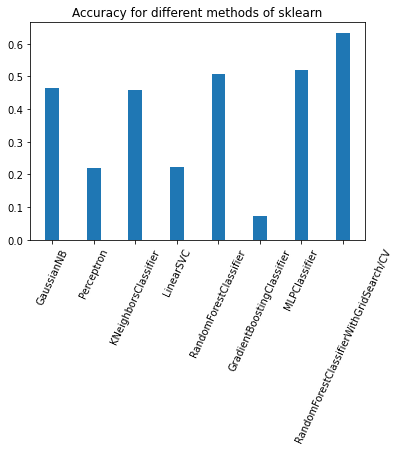

In [131]:
plt.bar(methods, scores, width = 0.33)
plt.title('Accuracy for different methods of sklearn')
plt.xticks(rotation=65)
plt.show()

## Conclusion

As shown by the previous scores, using PyTorch significantly outperform scikit-learn models. <br>
Simple approaches such as LinearSVC or GradientBoosting have clearly failed to accomplish this task.<br>
PyTorch with data augmentation was really efficient. <br>